## STOCK

In [20]:
#http://www.andrewshamlet.net/2017/07/13/python-tutorial-stochastic-oscillator/

In [42]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:

# Stochastic Oscilator %K
def STOK(close, low, high, n): 
 STOK = ((close - pd.Series.rolling(low, n).min()) / (pd.Series.rolling(high, n).max() - pd.Series.rolling(low, n).min())) * 100
 return STOK

# Stochastic Oscilator %D
def STOD(close, low, high, n):
 STOK = ((close - pd.Series.rolling(low, n).min()) / (pd.Series.rolling(high, n).max() - pd.Series.rolling(low, n).min())) * 100
 STOD = pd.Series.rolling(STOK, 3).mean()
 return STOD
 STOD


In [ ]:
def RSI(series, period):
    delta = series.diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
    d = d.drop(d.index[:(period-1)])
   # rs = pd.stats.moments.ewma(u, com=period-1, adjust=False) / \
   #      pd.stats.moments.ewma(d, com=period-1, adjust=False)
    rs= pd.Series.ewm(u,com=period-1, min_periods=0,adjust=False,ignore_na=False).mean() / \
        pd.Series.ewm(d,com=period-1,min_periods=0,adjust=False,ignore_na=False).mean()
    return 100 - 100 / (1 + rs)

In [62]:
import datetime 
from pandas import read_csv
from pandas import concat
import os.path

item='GM'
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime.now()

file_path='./data/'+item +'.csv'

#lastDate=df.index[df.shape[0]-1]
if not os.path.exists(file_path):
    print("Empty set")
    df =web.DataReader(item,'yahoo',start,end)  
    df.to_csv('./data/' + item + '.csv')
    df.index.name = 'Date'
else:
    print("Read from file")  
    df = read_csv(file_path)
    df.set_index("Date",inplace=True)

    end = datetime.datetime.now()
    lastDate=df.index[df.shape[0]-1] #last recorded day
    d1 = datetime.datetime.strptime(lastDate, "%Y-%m-%d %H:%M:%S")   
    print(d1,end )
    if( d1 < end - datetime.timedelta(days=2)): # dont update on Sat or Sun
        print("Updating")  
        d2 = d1 + datetime.timedelta(days=1)
        df1 =web.DataReader(item,'yahoo',d2,end)   
        print(df1)
        dft=pd.concat([df,df1])
        dft.to_csv('./data/' + item + '.csv')
#
df.shape

Empty set


(981, 6)

In [63]:
#df.set_index("Date",inplace=True)
#df.index.name
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,40.680000,41.060001,40.340000,40.950001,35.065094,14763300
2014-01-03,40.919998,40.950001,39.000000,39.570000,33.883408,41426900
2014-01-06,39.900002,40.590000,39.639999,40.400002,34.594135,25063500
2014-01-07,40.700001,40.939999,40.099998,40.200001,34.422874,14156900
2014-01-08,40.330002,40.840000,40.200001,40.419998,34.611259,11342400


In [64]:
from sklearn.preprocessing import LabelEncoder
df['%K'] = STOK(df['Close'], df['Low'], df['High'], 14)
df['%D'] = STOD(df['Close'], df['Low'], df['High'], 14)
df['Avg5'] =pd.Series.rolling(df['Close'],5).mean()
df['Avg10'] =pd.Series.rolling(df['Close'],10).mean()
#df['RSI14'] = RSI(df['Close'],14)
#df['RSI7'] = RSI(df['Close'],7)
df['Rise'] = (df['Close'] - pd.Series.rolling(df['Close'],5).min() > df['Close']*0.03 )*1
#df.tail()
df.shape

(981, 11)

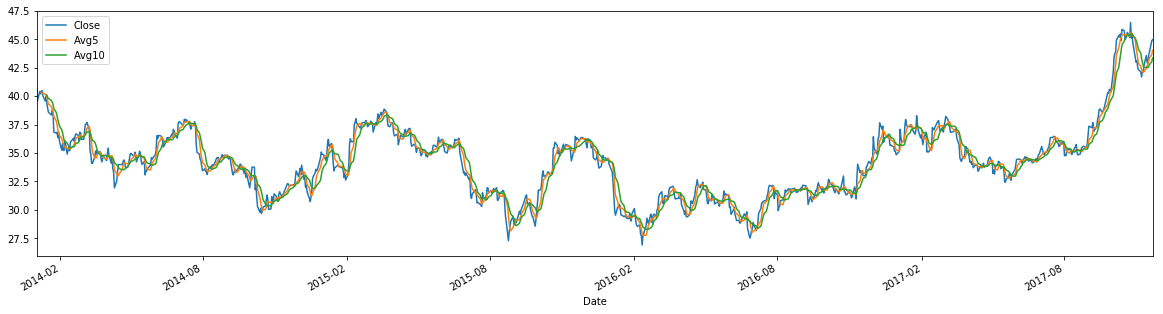

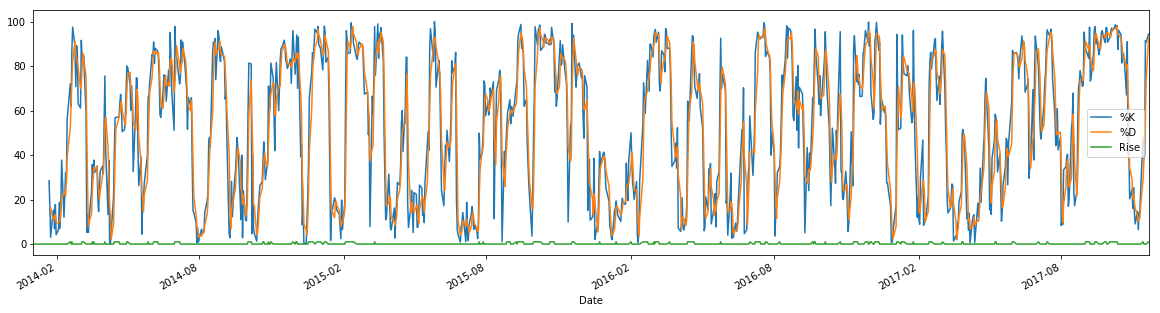

In [65]:
df.plot(y=['Close','Avg5','Avg10'], figsize = (20, 5))
df.plot(y=['%K', '%D','Rise'], figsize = (20, 5))

In [66]:
# convert series to supervised learning
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

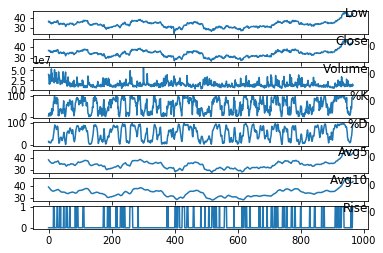

In [67]:
from matplotlib import pyplot

df.dropna(inplace=True)

values = df.values
# specify columns to plot
groups = [ 2, 3, 5, 6, 7,8,9,10]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(df.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [68]:
values[1]

array([  3.67999990e+01,   3.72799990e+01,   3.60600010e+01,
         3.67599980e+01,   3.14772320e+01,   3.39153000e+07,
         1.43442067e+01,   1.14864414e+01,   3.78299994e+01,
         3.85729998e+01,   0.00000000e+00])

In [69]:
'''values = np.array([[  10, 20, 30, 40, 50, 60, 0 ],
                  [  11, 21, 32, 43, 54, 65 ,0 ],
                  [  12, 22, 33, 44, 55, 66 ,1 ],
                  [  13, 23, 34, 45, 56, 67 ,1 ]])
values[1]'''

'values = np.array([[  10, 20, 30, 40, 50, 60, 0 ],\n                  [  11, 21, 32, 43, 54, 65 ,0 ],\n                  [  12, 22, 33, 44, 55, 66 ,1 ],\n                  [  13, 23, 34, 45, 56, 67 ,1 ]])\nvalues[1]'

In [70]:
from sklearn.preprocessing import MinMaxScaler

# ensure all data is float
values = values.astype('float')
#drop columns to simplify test
timesteps=3
features = values.shape[1]-1
# normalize features
scaler = MinMaxScaler()
#scaled = scaler.fit_transform(values)
scaled = values #scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled,timesteps, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17,18,19,20]], axis=1, inplace=True)
reframed= pd.DataFrame(reframed)
#print(reframed.head())
reframed.iloc[0]

var1(t-3)     3.807000e+01
var2(t-3)     3.811000e+01
var3(t-3)     3.670000e+01
var4(t-3)     3.683000e+01
var5(t-3)     3.153718e+01
var6(t-3)     3.956450e+07
var7(t-3)     3.066063e+00
var8(t-3)     1.619868e+01
var9(t-3)     3.819800e+01
var10(t-3)    3.890000e+01
var11(t-3)    0.000000e+00
var1(t-2)     3.680000e+01
var2(t-2)     3.728000e+01
var3(t-2)     3.606000e+01
var4(t-2)     3.676000e+01
var5(t-2)     3.147723e+01
var6(t-2)     3.391530e+07
var7(t-2)     1.434421e+01
var8(t-2)     1.148644e+01
var9(t-2)     3.783000e+01
var10(t-2)    3.857300e+01
var11(t-2)    0.000000e+00
var1(t-1)     3.716000e+01
var2(t-1)     3.720000e+01
var3(t-1)     3.672000e+01
var4(t-1)     3.681000e+01
var5(t-1)     3.152005e+01
var6(t-1)     1.592670e+07
var7(t-1)     1.536886e+01
var8(t-1)     1.092638e+01
var9(t-1)     3.752400e+01
var10(t-1)    3.829600e+01
var11(t-1)    0.000000e+00
var1(t)       3.606000e+01
var2(t)       3.696000e+01
var3(t)       3.601000e+01
var4(t)       3.635000e+01
v

In [71]:
values.shape

(966, 11)

In [72]:
# split into train and test sets
from keras.utils.np_utils import to_categorical
import numpy 

values = reframed.values
n_train_size = 600
train = values[:n_train_size, :]
test = values[n_train_size:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], to_categorical(train[:, -1])
#train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], to_categorical(test[:, -1])
#test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = numpy.reshape(train_X, (train_X.shape[0], train_X.shape[1], 1 ))
test_X = numpy.reshape(test_X, (test_X.shape[0], test_X.shape[1],1))

#train_X = train_X.reshape((1,train_X.shape[0], train_X.shape[1]))
#test_X = test_X.reshape((1,timesteps, features)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
#print(train_X[0:1,:])

(600, 43, 1) (600, 2) (363, 43, 1) (363, 2)


In [73]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
# design network
model = Sequential()


#this is good .92
model.add(LSTM(20, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(20))
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

'''#this is good .89
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(2, activation='sigmoid'))'''

'''#this is good .88
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(8, input_dim=3, activation='relu'))
model.add(Dense(2, activation='sigmoid'))'''

#Dense expects a 2-dimensional input (batch_size, features), 
#whereas the output of LSTM with return_sequences is 3 dimensional (batch_size, timesteps, features).

#stacked --good acc =0.843
'''model.add(LSTM(4, input_shape=(43, 1)))
model.add(Dense(2, activation='sigmoid'))
print(model.summary())'''

'''model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))'''


#model.compile(loss='mae', optimizer='adam')
# it should be categorical
#model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 43, 20)            1760      
_________________________________________________________________
lstm_13 (LSTM)               (None, 20)                3280      
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 168       
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 18        
Total params: 5,226
Trainable params: 5,226
Non-trainable params: 0
_________________________________________________________________
None


In [74]:
# fit network
#history = model.fit(train_X, train_y, epochs=10, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#history = model.fit(train_X, train_y, epochs=20, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history=model.fit(train_X, train_y, epochs=100, batch_size=1, verbose=2)
# plot history
'''pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()'''

Epoch 1/100
25s - loss: 0.4827 - acc: 0.8283
Epoch 2/100
23s - loss: 0.4509 - acc: 0.8283
Epoch 3/100
25s - loss: 0.4322 - acc: 0.8283
Epoch 4/100
30s - loss: 0.3970 - acc: 0.8267
Epoch 5/100
30s - loss: 0.3701 - acc: 0.8250
Epoch 6/100
30s - loss: 0.3317 - acc: 0.8517
Epoch 7/100
30s - loss: 0.3136 - acc: 0.8617
Epoch 8/100
30s - loss: 0.3045 - acc: 0.8817
Epoch 9/100
32s - loss: 0.3033 - acc: 0.8733
Epoch 10/100
31s - loss: 0.2831 - acc: 0.8900
Epoch 11/100
30s - loss: 0.2979 - acc: 0.8817
Epoch 12/100
30s - loss: 0.2978 - acc: 0.8667
Epoch 13/100
30s - loss: 0.2834 - acc: 0.8883
Epoch 14/100
30s - loss: 0.2930 - acc: 0.8900
Epoch 15/100
31s - loss: 0.2918 - acc: 0.8700
Epoch 16/100
30s - loss: 0.2819 - acc: 0.8733
Epoch 17/100
30s - loss: 0.2797 - acc: 0.8850
Epoch 18/100
30s - loss: 0.2785 - acc: 0.8833
Epoch 19/100
30s - loss: 0.2669 - acc: 0.8900
Epoch 20/100
30s - loss: 0.2752 - acc: 0.8850
Epoch 21/100
30s - loss: 0.2753 - acc: 0.8833
Epoch 22/100
31s - loss: 0.2562 - acc: 0.88

"pyplot.plot(history.history['loss'], label='train')\npyplot.plot(history.history['val_loss'], label='test')\npyplot.legend()\npyplot.show()"

In [75]:
# serialize model to JSON
model_json = model.to_json()
with open("./data/" + item + "_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("./data/" + item + "_model.h5")
print("Saved model to disk")


Saved model to disk


In [76]:
# later...
# load json and create model
from keras.models import model_from_json

json_file = open('./data/' + item +'_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./data/' + item +'_model.h5')
print("Loaded model from disk")
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy']) #61.29
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate( test_X, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 87.05%


In [77]:
# make a prediction
#test_X.shape
yhat = model.predict(test_X)
#yhat = model.predict(train_X)
#test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [79]:
#Reverse categorical
from numpy import argmax
argmax(yhat,axis=1)

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0,

In [80]:
argmax(test_y,axis=1)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

In [81]:
yhat[10]
argmax(yhat[10])

1

In [82]:
values[10]

array([  3.59700010e+01,   3.64700010e+01,   3.54199980e+01,
         3.61100010e+01,   3.09206450e+01,   3.12480000e+07,
         3.77155254e+01,   2.10606866e+01,   3.55300006e+01,
         3.60490002e+01,   0.00000000e+00,   3.59100000e+01,
         3.59199980e+01,   3.46199990e+01,   3.49000020e+01,
         2.98845330e+01,   4.32684000e+07,   1.21076485e+01,
         2.27258649e+01,   3.54600010e+01,   3.58630006e+01,
         0.00000000e+00,   3.52200010e+01,   3.57400020e+01,
         3.51899990e+01,   3.52500000e+01,   3.01842380e+01,
         2.37724000e+07,   2.14975656e+01,   2.37735798e+01,
         3.53460010e+01,   3.57070005e+01,   0.00000000e+00,
         3.54900020e+01,   3.56500020e+01,   3.51300010e+01,
         3.55600010e+01,   3.04496880e+01,   2.33009000e+07,
         3.20000000e+01,   2.18684047e+01,   3.54100008e+01,
         3.56280008e+01,   0.00000000e+00])

In [59]:
values[10,:]

array([ 0.03852263,  0.03150303,  0.03530217,  0.02953714,  0.03021936,
        0.32847463,  0.4099467 ,  0.31312716,  0.01433132,  0.00343808,  0.        ])

In [68]:
df.values[10,:]

array([  7.44828570e+01,   7.47042850e+01,   7.39114300e+01,
         7.42399980e+01,   6.94897990e+01,   9.25701000e+07,
         4.09946700e+01,   3.35373005e+01,   7.30028566e+01,
         7.30461419e+01,   0.00000000e+00])

In [ ]:
def custom_index(array, compare_function):

  for i, v in enumerate(array):

    if compare_function(v):

      return i